# Lista 2
## Vinicius Julião Ramos - 2018054630

> Os resultados e o resumo das respostas estão nas céluas em markdown que se iniciam com "Resposta".

In [1]:
# setwd("./../utils")
source("../utils/graficos.r")
source("../utils/funcoesAuxiliares.r");
loadPackage("quantmod");
loadPackage("quadprog");
library("reshape2")
library("ggplot2")

options(scipen=999);
loadPackage("RCurl");
data <- getURL("http://www.dcc.ufmg.br/~arbex/portfolios/IBOV.csv", ssl.verifypeer=0L, followlocation=1L);
prices = read.csv(text = data, header = TRUE, sep = ",", stringsAsFactors = FALSE);
begin  = which(prices[,1] > 20190000)[1];
end    = which(prices[,1] > 20200000)[1];
os.prices = prices[end:nrow(prices), ];
is.prices = prices[begin:end, ];

## Questão 1

validar que PETR3 é $I(1)$ pelo teste de Dickey-Fuller

In [2]:
loadPackage('tseries')
q1_prices = prices[prices$Date > 20180000 & prices$Date <= 20200000,]

# Validar que petr3 é I(1)
petr3 = q1_prices[['PETR3']]
for (i in 2 : length(petr3)) { if (is.na(petr3[i])) petr3[i] = petr3[i-1]}
cat("PETR3\n")
cat("P-value antes de obter a primeira diferenciação: ", toString(suppressWarnings(adf.test(petr3, alternative = "stationary")[4])))
petr3.i0 = diff(petr3);
cat("\nP-value após a diferenciação: ", toString(suppressWarnings(adf.test(petr3.i0, alternative = "stationary")[4])))

PETR3
P-value antes de obter a primeira diferenciação:  0.0400891095079282
P-value após a diferenciação:  0.01

1. obter todas as séries que podem ser $I(1)$ através de Dickey-Fuller
2. Para tais séries validar qual é o valor de `alpha` e `beta` para $Y = \alpha + \beta X + \epsilon$

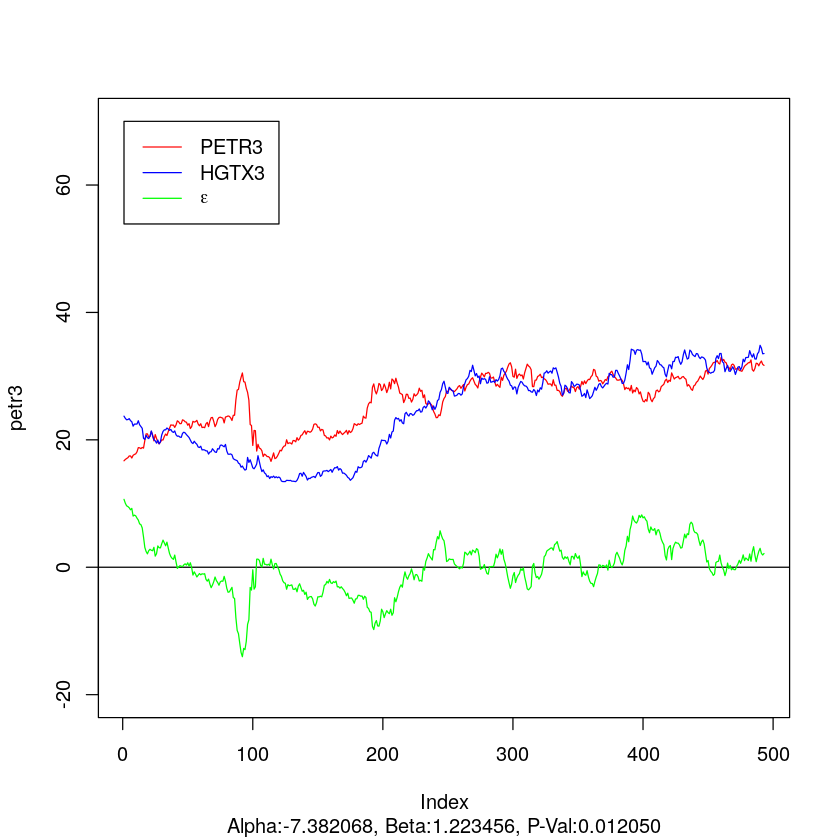

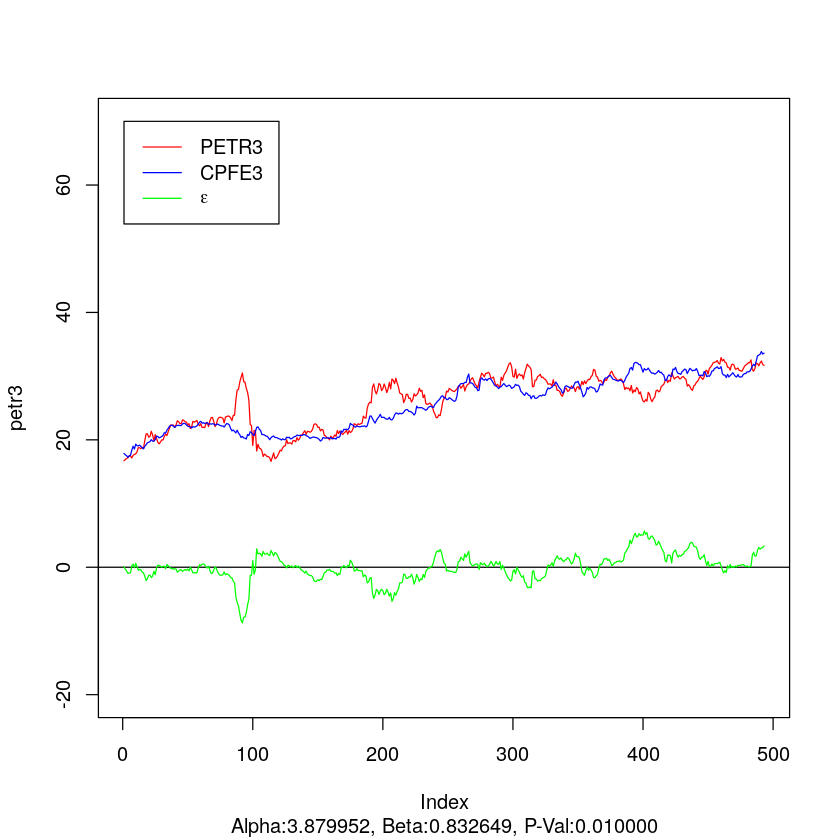

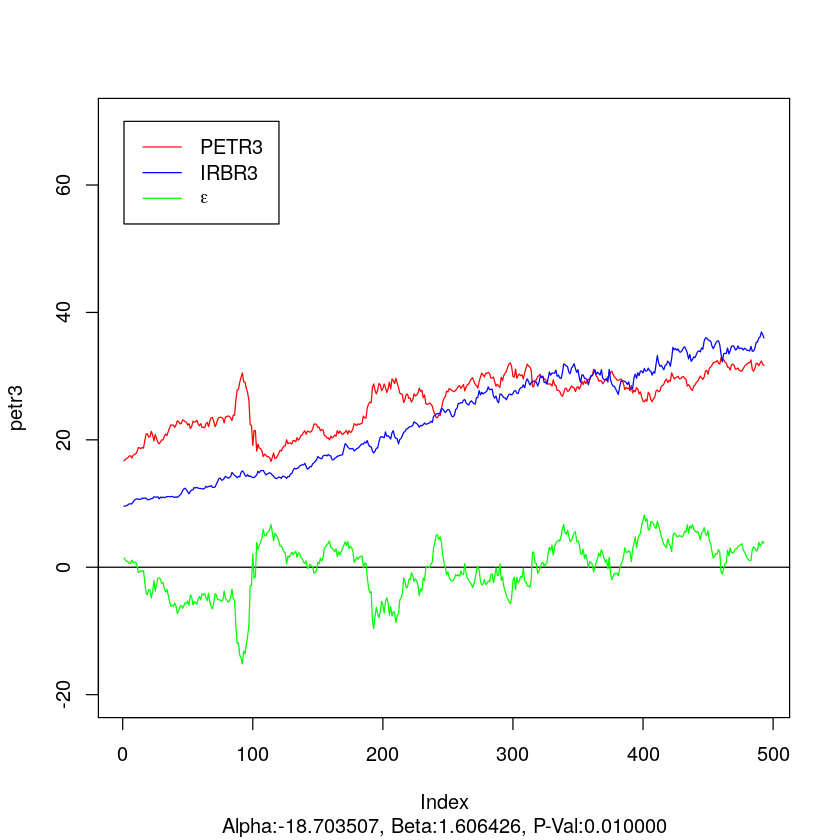

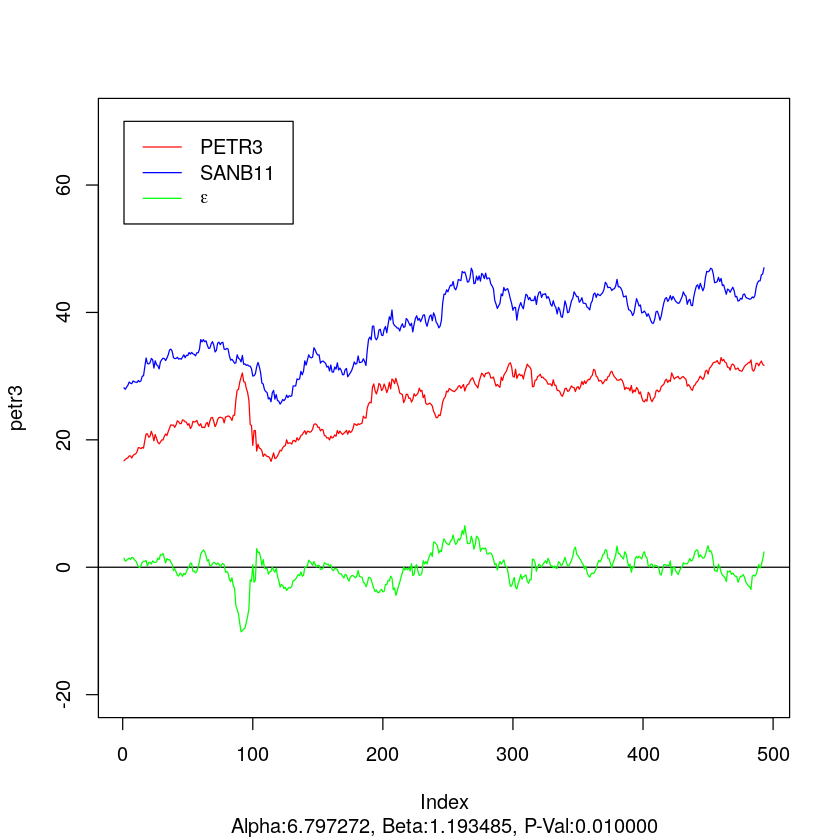

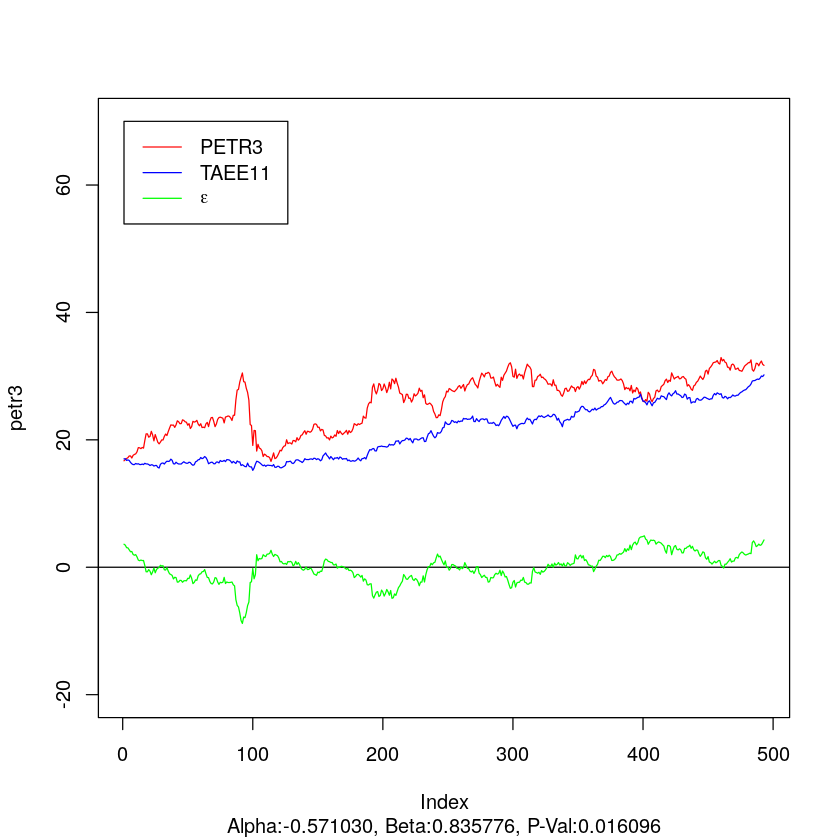

In [3]:
q1_prices$Date <- NULL
q1_prices$PETR3 <- NULL

# Obter todos os ativos que possívelmente são I(1)
i0_prices = data.frame()[1:length(petr3.i0), ]
for(name in colnames(q1_prices)) {
    ativo = q1_prices[[name]]
    for (j in 2 : length(ativo)) { if (is.na(ativo[j])) ativo[j] = ativo[j -1]}
    ativo.i0 = diff(ativo)
    pval.i1 = as.numeric(suppressWarnings(adf.test(ativo, alternative = "stationary")[4]))
    pval.i0 = as.numeric(suppressWarnings(adf.test(ativo.i0, alternative = "stationary")[4]))
    if(pval.i1  <= 0.01 || pval.i0 > 0.01){
        q1_prices[name] <- NULL
    }
}

# encontrando os pares cointegrados com petr3    
show_cointegrated = function(name) {
    Y <- q1_prices[[name]]
    model <- lm(Y~petr3)
    alpha = model$coefficients[1]
    beta = model$coefficients[2]
    epsilon = Y - alpha - (beta*petr3)
    epsilon.pval = as.numeric(suppressWarnings(adf.test(epsilon, alternative = "stationary")[4]))
    # provavelmente é cointegrado
    if(epsilon.pval <= 0.02){
         
        plot(petr3, type="l", col="red", ylim = c(-20, 70))
        abline(h = mean(epsilon), col="black")
        lines(Y, col="blue")
        lines(epsilon, col="green")
        title(sub=sprintf("Alpha:%f, Beta:%f, P-Val:%f", alpha, beta, epsilon.pval),
              xlab="", ylab="")
        legend(1, 70, legend=c("PETR3",  name, expression(epsilon)),
           col=c("red", "blue", "green"), lty=1, cex=1.)
    }
}
for(name in colnames(q1_prices)) {
    show_cointegrated(name)
}

In [4]:
jpeg("Q1_SANB11.jpg", width = 500, height = 500)
show_cointegrated('SANB11')
dev.off()
jpeg("Q1_IRBR3.jpg", width = 500, height = 500)
show_cointegrated('IRBR3')
dev.off()
jpeg("Q1_CPFE3.jpg", width = 500, height = 500)
show_cointegrated('CPFE3')
dev.off()

png 
  2

png 
  2

png 
  2

### Resposta 1

Considere que na expressão $Y = \alpha+\beta X + \epsilon$, $X$ represente o ativo PETR3 e $Y$ representa um dos ativos escolhidos pela observação do gráfico acima.

Tomando alguns dos valores então observados, temos que:
- SANB11\
  $\alpha=-0.51, \beta=0.70$\
  $Y_{SANB11} = -0.51 + 0.7X_{PETR3} + \epsilon$
- IRBR3\
  $\alpha=15.51, \beta=0.46$\
  $Y_{IRBR3} = 15.51 + 0.46X_{PETR3} + \epsilon$
- CPFE3\
  $\alpha=3.37,\ \beta=0.89$\
  $Y_{CPFE3} = 3.37 + 0.89X_{PETR3} + \epsilon$

Dada tal escolha, e observamos que é possível realizar uma estratégia de pairs trading e obter lucro. Os pesos utilizados nos pares entre PETR3 e o outro ativo se basearia no fator $\beta$ da relação linear, em que com um ativo poderíamos entrar em long, enquanto o outro abriríamos uma posição shorting, a fim de que estas operações neutralizem o risco entre si.
Um exemplo seria realizar shorting em PETR3 e long em SANB11, assim, caso houvesse alguma queda de SANB11, ela seria coberta pela queda de PETR3. Já o prejuízo dado por uma possível aumento em PETR3, seria (mesmo que em partes) neutralizado pelo aumento também em SANB11.

Os gráficos correspondentes a estes ativos são mostrados a seguir:

![sanb](./Q1_SANB11.jpg)
![irbr](./Q1_IRBR3.jpg)
![cpfe](./Q1_CPFE3.jpg)

## Questão 2

In [5]:
insample = prices[prices$Date > 20190000 & prices$Date <= 20200000,]
outsample = prices[prices$Date > 20200000,]

# removendo as colunas 'Date' e 'IBOV'
insample.prices = is.prices[,3:ncol(insample)];
outsample.prices = os.prices[,3:ncol(outsample)];

# calculo da matriz de retornos simples
insample.returns = apply(insample.prices, 2, function(x){diff(x)/x[-length(x)]} );
outsample.returns = apply(outsample.prices, 2, function(x){diff(x)/x[-length(x)]} );

# calculo do vetor de retornos esperados (mu) e matriz de covariancias (Sigma)
insample.mu = matrix(colMeans(insample.returns), nrow=1)
colnames(insample.mu) = colnames(insample.returns);
insample.Sigma = cov(insample.returns);


### 2.a
Obtendo o portifólio de variância mínima

In [6]:
q2a.topo  = cbind(2*insample.Sigma, rep(1, nrow(insample.Sigma)));
q2a.fundo = c(rep(1, ncol(insample.Sigma)), 0);
q2a.A = rbind(q2a.topo, q2a.fundo);
q2a.b = c(rep(0, nrow(insample.Sigma)), 1);

p1.z = solve(q2a.A) %*% q2a.b;
p1.weights = p1.z[1:ncol(insample.Sigma),1];

# print(length(p1.weights))
p1.mu = as.numeric(crossprod(p1.weights, as.vector(insample.mu)))

p1.sigma2 = as.numeric(t(p1.weights) %*% insample.Sigma %*% p1.weights);
p1.sigma = sqrt(p1.sigma2)
p1.chart.data <- p1.weights[p1.weights >= 0.0001 || p1.weights <= -0.0001]

In [7]:
cat("p1.mu =",p1.mu)
cat("\np1.sigma =",p1.sigma)

ggOptions = getGGOptions();
ggOptions$barChart = 1;
ggOptions$height = 6;
ggOptions$width = 10;
ggOptions$axisTitleSize = 16;
ggOptions$axisXLabelSize = 8;
ggOptions$axisYLabelSize = 14;
ggOptions$xTitle = "Ativo";
ggOptions$yTitle = "Peso";
ggOptions$percentageInYAxis = 1;
ggOptions$axisXLabelAngle = 90;
ggOptions$title = "Pesos do portfolio p1";
ggOptions$saveGraphics = 1;
ggOptions$imageName = "Q2A.png";
plotGraph(p1.chart.data, xValues = names(p1.chart.data), ggOptions = ggOptions)

p1.mu = 0.001154278
p1.sigma = 0.006071116

null device 
          1

### Resposta 2.a

Sumarizando as ações feitas anteriormente e a obtenção dos resultados, temos que:
   - $\mu_{p1} = 0.001154278$
   - $\sigma_{p1} = 0.006071116$

O gráfico dos pesos também é dado acima, e podemos observar que o range máximo em que os pesos do portifólio de variância mínima global está aproximadamente entre $(-2, 2)$.\
![resultado](./Q2A.png)

### 2.b

resolver o problema de minimização, com adicionando a restrição de que os pesos $w_i$ são maiores ou iguais a $0$.

In [8]:
N = ncol(insample.returns)
q2b.D = insample.Sigma; # Q do modelo
q2b.d = rep(0, N);      # c do modelo
q2b.A = matrix(c(rep(1, N),
                insample.mu, 
                diag(N)),
              ncol = N, 
              byrow = TRUE);
q2b.b = c(1, 0, rep(0, N));
q2b.meq  = 1;

q2b.result <- solve.QP(Dmat = q2b.D, dvec = q2b.d, Amat=t(q2b.A), bvec=q2b.b, meq=q2b.meq);

p2.weights = q2b.result$solution

names(p2.weights) <- colnames(insample.prices)
p2.mu = as.numeric(crossprod(p2.weights, as.vector(insample.mu)))
p2.sigma2 = (q2b.result$val)*2
p2.sigma = sqrt(p2.sigma2)

p2.chart.data <- p2.weights[p2.weights>= 0.0001]

In [9]:
cat("p2.mu =",p2.mu)
cat("\np2.sigma =",p2.sigma)

ggOptions$imageName = "Q2B.png";
ggOptions$title = "Pesos do portfolio p2";
plotGraph(p2.chart.data, xValues = names(p2.chart.data), ggOptions = ggOptions)

p2.mu = 0.001592584
p2.sigma = 0.007689997

null device 
          1

### Resposta 2.b

   - $\mu_{p2} = 0.001592584$
   - $\sigma_{p2} = 0.007689997$

Assim como especificado pela restrição do problema de minimização, temos que aqui os ativos devem conter apenas pesos maiores ou iguais a $0$. é possivel observar, ainda, que o maior peso é de cerca de $17\%$.

![resultado](./Q2B.png)

### 2.c

Utilizaremos quase a mesma instancia do problema anteior, entretanto agora desejamos obter um retorno esperado minimio de $0.3\%$. Isso sugere que o vetor $b$, terá uma restrição para tal valor.

In [10]:
q2c.D <- q2b.D
q2c.d <- q2b.d
q2c.A <- q2b.A
q2c.b = c(1, 0.003, rep(0, N));
q2c.meq  = 1;
q2c.result <- solve.QP(Dmat = q2c.D, dvec = q2c.d, Amat=t(q2c.A), bvec=q2c.b, meq=q2c.meq);

p3.weights = q2c.result$solution

names(p3.weights) <- colnames(insample.prices)
p3.mu = as.numeric(crossprod(p3.weights, as.vector(insample.mu)))
p3.sigma2 = (q2c.result$val)*2
p3.sigma = sqrt(p3.sigma2)

p3.chart.data <- p3.weights[p3.weights>= 0.0001]

In [11]:
cat("p3.mu =",p3.mu)
cat("\np2.sigma =",p3.sigma)

ggOptions$imageName = "Q2C.png";
ggOptions$title = "Pesos do portfolio p3";
plotGraph(p3.chart.data, xValues = names(p3.chart.data), ggOptions = ggOptions)

p3.mu = 0.003
p2.sigma = 0.008913589

null device 
          1

### Resposta 2.c

   - $\mu_{p3} = 0.003$
   - $\sigma_{p3} = 0.008913589$

Uma vez que foi especificado que o retorno esperado mínimo deveria ser de $0.3\%$, obtivemos pela solução exatamente tal valor. Uma possível explicação para esse fato é de que ao obter um retorno esperado maior do que $0.3\%$ a variância poderia ser maior, e consequentemente o risco associado ao portfolio. Como a idéia é minimizar o risco, obter um valor de $\mu_{p3} \gt 0.3\%$ pode tornar $p3$ um portfolio mais arriscado.

![resultado](./Q2C.png)

## 2.d
Aplicaremos o 

In [12]:
data.frame(outsample.returns)[names(p3.chart.data)]

,BRFS3,BPAC11,CSAN3,CPFE3,HAPV3,GNDI3,IRBR3,JBSS3,BEEF3,QUAL3,RADL3,RAIL3,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,WEGE3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3214,0.001672241,0.0006651590,0.019512890,-0.006308201,0.0422513958,0.0187648789,-0.0075963104,0.009778112,0.0262529833,0.020668538,-0.0222785252,-0.0291666667,-0.007498296,0.0405162555,-0.003432214,0.0003335557,0.0019144863,0.021304348,-0.012575021
3215,-0.010294936,-0.0116990162,-0.006007265,0.009371221,-0.0308382800,-0.0412371134,-0.0095680700,-0.023836127,-0.0007751938,0.041000000,-0.0197480118,-0.0284822474,-0.024725275,-0.0067514523,-0.001722017,0.0010003334,-0.0012738854,-0.022988506,0.002604920
3216,-0.011526567,0.0115684692,0.018130710,-0.011380653,-0.0274873021,-0.0341218638,0.0066243445,0.017932087,0.0457719162,-0.025456292,-0.0136736554,0.0148594378,0.000000000,-0.0134366108,0.012814194,-0.0083277815,0.0108418367,0.004357298,0.007794457
3217,0.038395904,-0.0066489362,-0.016565433,-0.006361709,-0.0205837174,0.0059373608,0.0038387716,0.024737631,0.0111275964,-0.019221291,0.0133086876,0.0130589632,-0.001408451,-0.0033648454,0.049878345,-0.0201545180,0.0107255521,-0.013449024,-0.038097966
3218,0.009038620,0.0093708166,-0.010668164,0.017987805,-0.0059598494,0.0053120850,0.0387872166,0.012070227,-0.0154071900,0.007286432,0.0300985042,0.0128906250,-0.010578279,0.0250803859,-0.002549247,0.0051422695,-0.0137328340,0.016710642,-0.014592019
3219,-0.013572204,-0.0001326260,0.014897843,0.019167415,-0.0213000947,0.0060179069,0.0005259006,-0.005421034,-0.0044709389,0.013719132,-0.0309899061,-0.0100269958,0.011404134,-0.0092534504,0.001626394,0.0030695771,0.0265822785,-0.007785467,0.020247809
3220,0.009906439,0.0058363178,0.025583671,-0.003820159,0.0054812188,0.0172162241,0.0084099869,0.020348837,0.0898203593,0.031988189,0.0234831871,0.0109076743,0.060606061,-0.0226373278,0.036882394,0.0112206732,0.0006165228,0.009590235,0.009478673
3221,-0.004087193,-0.0174073586,0.031897492,-0.007374631,0.0017636684,0.0137693632,-0.0067761272,-0.001068376,-0.0075549451,0.024082022,0.0149093831,-0.0057803468,-0.015946844,0.0242954325,-0.010067114,0.0033624748,0.0043130006,0.000000000,0.019953052
3222,-0.002188782,-0.0068447188,-0.016512550,0.007132244,-0.0238476312,0.0275891341,0.0236158489,-0.003208556,-0.0034602076,-0.013271246,0.0029908515,-0.0321705426,-0.013504389,-0.0169196711,0.015593220,-0.0033512064,0.0006134969,0.002590674,0.006616801


In [13]:

q2d.returns <- outsample.returns
rownames(q2d.returns) <- 1:nrow(outsample.returns)


apply_portfolio <- function(weights, prices, returns){
    result <- prices[names(weights)]
    rownames(result) <- 1:nrow(prices)
    result[1,] <- weights
    
    for(i in 1:nrow(returns)){
#       rebalanceamento sem alterar a estratégia
        next_day <- (1+returns[i,])*result[i,]
        money <- sum(next_day)
        result[i+1,] <- weights * money
        
#       Buy and Hold  
#         result[i+1,]<- (1+returns[i,])*result[i,]
    }
    return (rowSums(result));
}
ibov <- c(os.prices$IBOV)
ibov <- ibov/ibov[1]

q2d.p1 <- apply_portfolio(p1.chart.data, outsample.prices, q2d.returns)
q2d.p2 <- apply_portfolio(p2.chart.data, outsample.prices, q2d.returns)
q2d.p3 <- apply_portfolio(p3.chart.data, outsample.prices, q2d.returns)

jpeg("Q2D.jpg", width = 500, height = 500)
plot(q2d.p1, type="l", col="red", ylim=c(0.5,1.1), xlab="", ylab="")
lines(q2d.p2, col="blue")
lines(q2d.p3, col="green")
lines(ibov, col="black")
title(main="Performance dos portfolios em out-sample",
      xlab=" ", ylab="Valor em R$")
legend("topright", legend=c("p1", "p2", "p3", "IBOV"),
  col=c("red", "blue", "green", "black"), lty=1, cex=1.)
dev.off();

png 
  2

### Resposta 2.d

Os portfolios foram aplicados com rebalanceamento diário.
Observando o gráfico, podemos desvrever uma melhor performance do portfolio $p2$ em relação aos demais e inclusive ao índice IBOV.
Como os dados de *out-of-sample* são referentes ao ano de 2020, sabe-se que este foi um ano de crise do mercado financeiro, em que no fim do primeiro trimestre aconteceu uma forte queda nos preços. Como a posição inicial se deu no ulitmo dia do ano de 2019, é normal que os preços tenham caído.
Entretanto, $p2$ se recuperou quase por completo da crise.

Um outro fato também observável é de que $p1$ é o portfolio de variância mínima, e isso é refletido no gráfico pela linha vermelha. Após a forte queda (que aconteceu para todos os ativos da B3) o ativo variou menos com relação aos demais, inclusive a queda foi menor em $p1$. Entretanto, essa redução de risco também impacta no retorno, o que fez com que esse portfolio não tivesse uma boa recuperação após a crise.

![q2d](./Q2D.jpg)

### Questão 2.e

Calculo da média e do desvio padrão para a aplicação dos portfolios em outsample.

In [14]:
outsample.mu = matrix(colMeans(outsample.returns), nrow=1)
colnames(outsample.mu) = colnames(outsample.returns);
outsample.Sigma = cov(outsample.returns);

show_stats <- function(sample.mu, sample.Sigma, weights, port_name){
    result.mu = as.numeric(crossprod(weights, as.vector(sample.mu)))
    result.sigma2 = as.numeric(t(weights) %*% sample.Sigma %*% weights);
    result.sigma = sqrt(result.sigma2)
    
    cat(port_name, ": mu:", result.mu, "sigma:", result.sigma,"\n")
}

show_stats(outsample.mu, outsample.Sigma, p1.weights, "p1")
show_stats(outsample.mu, outsample.Sigma, p2.weights, "p2")
show_stats(outsample.mu, outsample.Sigma, p3.weights, "p3")
mean(diff(q2d.p1))
mean(diff(q2d.p2))
mean(diff(q2d.p3))

p1 : mu: -0.001469393 sigma: 0.02239166 
p2 : mu: -0.0004406035 sigma: 0.02755771 
p3 : mu: 0.0009575545 sigma: 0.03136865 


[1] -0.001521031

[1] -0.0007224489

[1] -0.001002199

### Resposta 2.e

- $p1$: $\mu: -0.001469393$ $\sigma: 0.02239166$
- $p2$: $\mu: -0.0004406035$ $\sigma: 0.02755771$
- $p3$: $\mu: 0.0009575545$ $\sigma: 0.03136865$

Os resultados não são condizentes para o que foi calculado em *in-sample*. Isso pode se dar o fato de que houve um comportamento anômalo no período *out-sample*, que é uma crise repentia que causou uma forte queda nos preços. Além disso essa queda foi acompanhada por um forte movimento de alta (que fora dado num período maior de tempo).
Então há uma grande discrepância entre os retornos de *in-sample* e *out-sample*, o que explica tal diferença.


## Questão 3
### Resposta 3.a

Uma vez que é necessário adicionar novas restrições referente aos pesos $w_i$, duas novas restrições seriam adicionadas ao problema de otimização:
$$
w_i \geq -0.1\ \forall i\\
w_i \leq 0.1\ \forall i
$$

### Resposta 3.b

Dado um conjunto de indíces $W$ em que um ativo $a_j$ é do setor de tecnologia se e somente se $j \in W$, adicionaremos uma restrição baseadad na soma dos pesos $w_j$ tal que $j\in W$. Isso se dá da seguinte maneira:
$$
\sum_{j\in W}w_j \leq 0.3
$$

